In [1]:
import pandas as pd
import nltk
import spacy
import torch
from matplotlib import pyplot as plt
from wordcloud import WordCloud

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from tqdm import tqdm

tqdm.pandas()

In [4]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# EDA

In [5]:
df = pd.read_csv("./data/KyivChannels_Dataset_v01.csv", converters={"Date": pd.to_datetime})
df

channelname                Date  \
0      kyivpolitics 2023-08-01 09:45:38   
1      kyivpolitics 2023-08-01 10:03:38   
2      kyivpolitics 2023-08-01 14:42:31   
3      kyivpolitics 2023-08-01 15:37:34   
4      kyivpolitics 2023-08-01 13:06:08   
...             ...                 ...   
31177     hmarochos 2023-10-27 04:56:20   
31178     hmarochos 2023-10-27 06:12:15   
31179     hmarochos 2023-10-27 05:38:42   
31180   semenovatut 2023-10-27 11:50:39   
31181   darnicalive 2023-07-31 21:54:53   

                                                 content lang  
0      Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  
1      На 8 перекрестках Киева в пилотном режиме внед...   ru  
2      ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  
3      Завтра синоптики прогнозируют небольшой дождь ...   ru  
4      А вот и сам снятый советский герб \n\nКиев. Гл...   ru  
...                                                  ...  ...  
31177  🎨 Художницю зобовʼязали замалювати мурал на Сі...   uk  
31178  🚧 Львів хоче отримати 50 млн євро на реконстру...   uk  
31179  🙈 На Набережно-Хрещатицькій самовільно влаштув...   uk  
31180  Може залишити Пушкіна?\nБуде об‘єктом перформа...   uk  
31181  В Москва-сіті знову бавовняно 🔥🔥🔥\n\nГарної но...   uk  

[31182 rows x 4 columns]

In [6]:
df.shape

(31182, 4)

In [7]:
df.isna().sum(axis=0)

channelname    0
Date           0
content        0
lang           0
dtype: int64

In [8]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

In [9]:
# def detect_language(text):
#     lang, _ = langid.classify(text)
#     return lang
# 
# 
# df["lang"] = df["content"].apply(detect_language)
df["lang"].value_counts()

lang
uk    28465
ru     2112
en      147
bg       95
sr       77
be       58
ja       53
kk       39
zh       30
mk       23
mn       22
vi        8
ky        7
pl        5
sk        4
hr        3
qu        3
rw        3
bs        3
bn        2
fi        2
mt        2
ka        2
he        2
de        2
sq        1
mr        1
it        1
da        1
ps        1
sv        1
sl        1
fr        1
nn        1
et        1
hu        1
zu        1
hi        1
Name: count, dtype: int64

In [10]:
df[df['lang'] == 'en']['content']

271                                     -246.690
790                                     -247.230
889                             @lossolomas_kyiv
1081                                    -247.850
1297                     😂😂😂\n\n@lossolomas_kyiv
                          ...                   
30069                                   -295.510
30582    https://kvd.page.link/efeERSYLXeDNBA9M8
30710                                   -296.310
30904                                   -297.120
31110                                   -297.680
Name: content, Length: 147, dtype: object

As we see above, there little other languages except uk and ru, so we can remove them.

In [11]:
df = df[(df['lang'] == 'uk') | (df['lang'] == 'ru')]
df.head()

channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang  
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru

In [12]:
df.shape

(30577, 4)

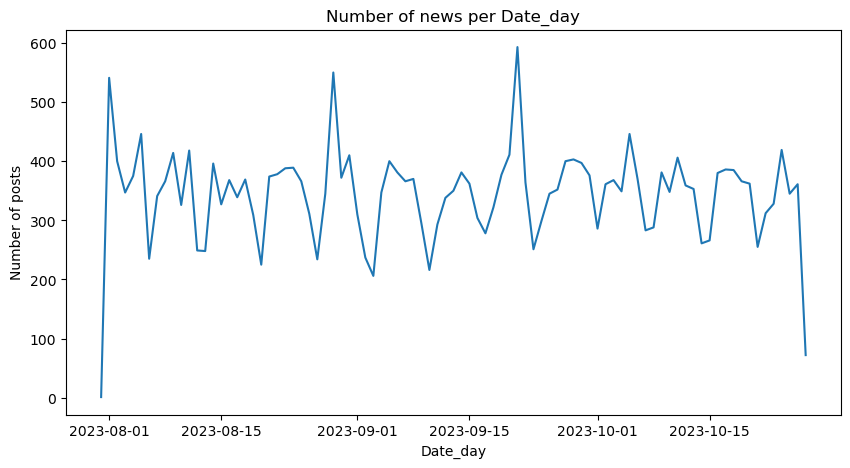

In [13]:
df["Date_day"] = df["Date"].apply(lambda x: x.date())
plt.figure(figsize=(10, 5))
plt.title("Number of news per Date_day")
df.groupby("Date_day")["content"].count().plot()
plt.xlabel("Date_day")
plt.ylabel("Number of posts")
plt.show()

# Preprocessing

## Cleaning and tokenization

Functions to clean and tokenize text. 

In [14]:
import re

tokenizer = {
    'uk': spacy.load("uk_core_news_sm"),
    'ru': spacy.load("ru_core_news_sm")
}


def clean_text(text):
    parts = text.rpartition('\n\n')
    cleaned_text = parts[0] if parts[0] else parts[-1]
    # Removing URLs
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', cleaned_text, flags=re.MULTILINE)

    # Removing emails
    cleaned_text = re.sub(r'\S*@\S*\s?', '', cleaned_text)

    # Removing bank card numbers
    cleaned_text = re.sub(r'\b(?:\d[ -]*?){13,16}\b', '', cleaned_text)

    # Removing payment details
    cleaned_text = re.sub(r'\b(?:\d[ -]*?){12,19}\b', '', cleaned_text)

    # Removing all the special characters
    cleaned_text = re.sub(r'\W', ' ', cleaned_text)

    # Removing all single characters
    cleaned_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleaned_text)

    # Removing single characters from the start
    cleaned_text = re.sub(r'\^[a-zA-Z]\s+', ' ', cleaned_text)

    # Substituting multiple spaces with single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text, flags=re.I)

    # Removing prefixed 'b'
    cleaned_text = re.sub(r'^b\s+', '', cleaned_text)

    # Converting to lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text.strip()


def preprocess_text(row, extra_stopwords=None):
    text, lang = row
    extra_stopwords = extra_stopwords or []
    
    # Tokenize the text
    tkn = tokenizer[lang]
    tkn.Defaults.stop_words |= set(extra_stopwords)
    tokens = tkn(text)

    # Remove stopwords
    tokens = [word.text for word in tokens if not word.is_stop and word.text not in extra_stopwords]
    return tokens

In [15]:
df['text'] = df['content'].progress_apply(clean_text)
df['tokens'] = df[['text', 'lang']].progress_apply(preprocess_text, axis=1)
df['token_text'] = df['tokens'].progress_apply(lambda x: ' '.join(x))
df.head()

100%|██████████| 30577/30577 [00:00<00:00, 536446.06it/s]


channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang    Date_day  \
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  2023-08-01   
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  2023-08-01   
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  2023-08-01   
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  2023-08-01   
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru  2023-08-01   

                                                text  \
0                       отбой угрозы для столицы нет   
1  на 8 перекрестках киева в пилотном режиме внед...   
2  нбу отозвал банковскую лицензию конкорд банка ...   
3  завтра синоптики прогнозируют небольшой дождь ...   
4                  а вот и сам снятый советский герб   

                                              tokens  \
0                           [отбой, угрозы, столицы]   
1  [8, перекрестках, киева, пилотном, режиме, вне...   
2  [нбу, отозвал, банковскую, лицензию, конкорд, ...   
3  [завтра, синоптики, прогнозируют, небольшой, д...   
4                          [снятый, советский, герб]   

                                          token_text  
0                               отбой угрозы столицы  
1  8 перекрестках киева пилотном режиме внедрят с...  
2  нбу отозвал банковскую лицензию конкорд банка ...  
3  завтра синоптики прогнозируют небольшой дождь ...  
4                              снятый советский герб

## Word clouds

In [16]:
def build_world_cloud(serie):
    plt.figure(figsize=(20, 20))
    plt.title("Original Text")
    wc = WordCloud(max_words=500, width=800, height=400).generate(" ".join(serie))
    plt.imshow(wc, interpolation='bilinear')

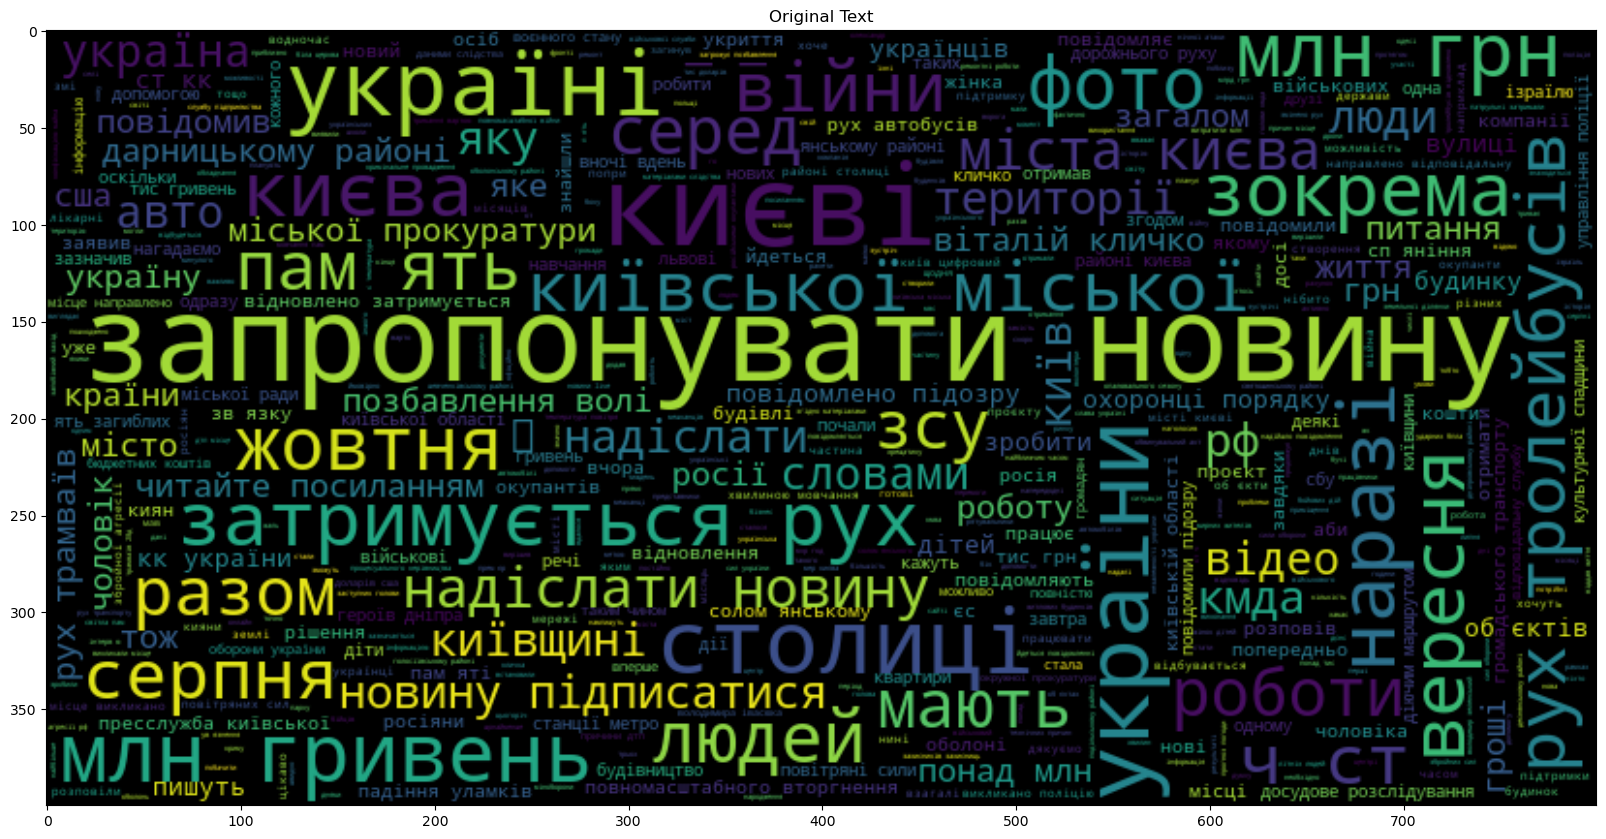

In [17]:
build_world_cloud(df[df['lang'] == 'uk']['token_text'])

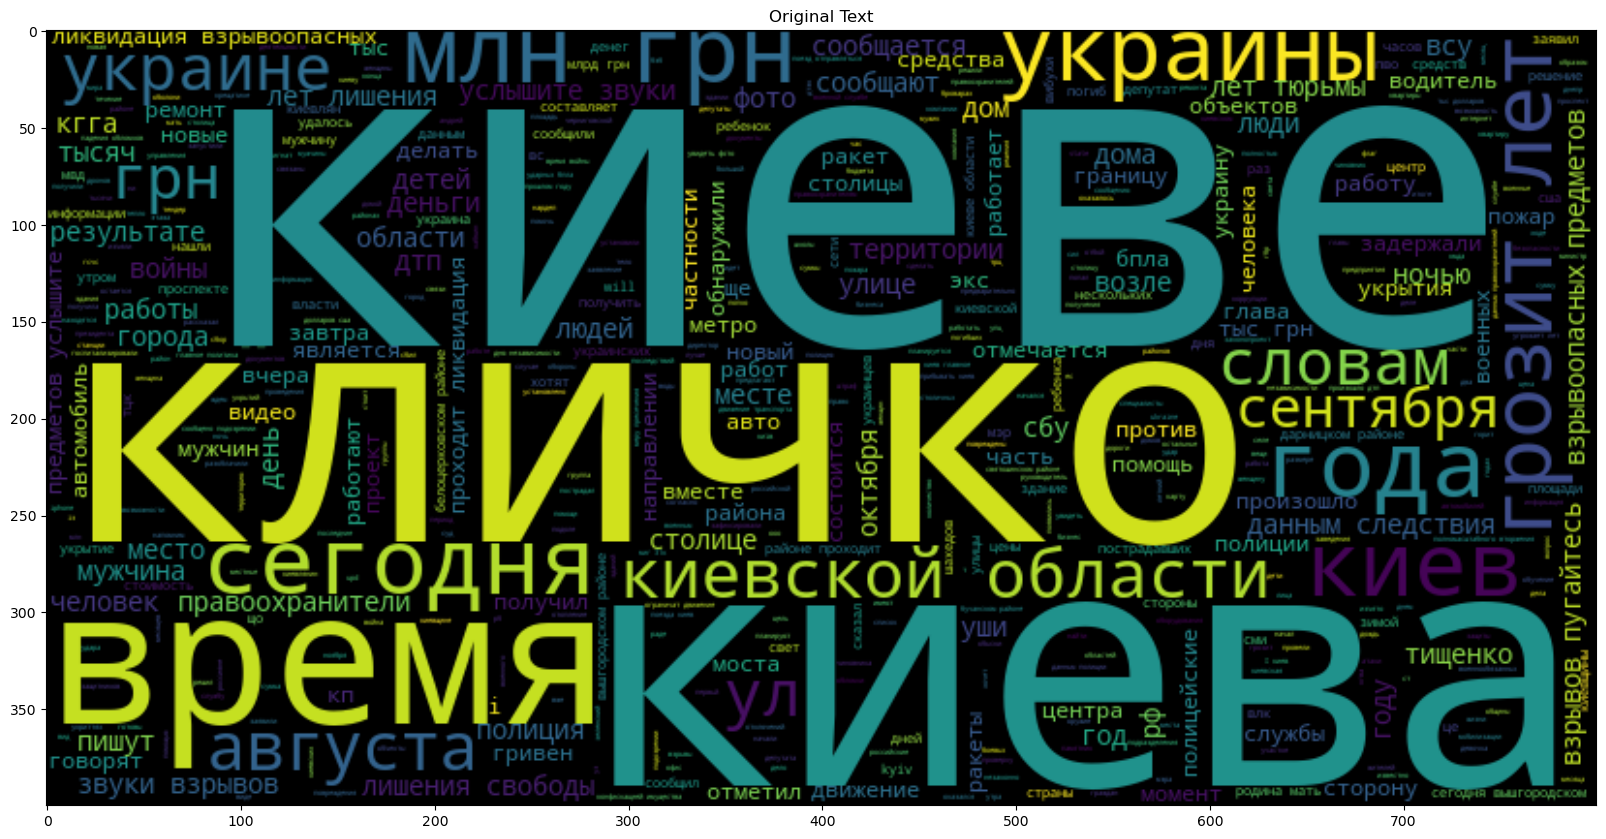

In [18]:
build_world_cloud(df[df['lang'] == 'ru']['token_text'])

As we see in word clouds above, there some words that are often found, but they don't have any useful information, so we can find them and add to stop words.

Below, there is a function to find `n` most common words: 

In [19]:
from collections import Counter


# Assuming df is your DataFrame and 'text_column' is the column with the text
def get_most_common_words(df, text_column, num_common_words):
    # Combine all the text into one large string
    combined_text = df[text_column].str.cat(sep=' ')

    # Split the text into words
    words = combined_text.split()

    # Count the occurrences of each word
    word_counts = Counter(words)

    # Get the most common words
    most_common_words = word_counts.most_common(num_common_words)

    return [word[0] for word in most_common_words]

In [20]:
get_most_common_words(df[df['lang'] == 'uk'], 'token_text', 20)

['україни',
 'києві',
 'києва',
 'вул',
 'новину',
 '1',
 'районі',
 '2',
 'столиці',
 'запропонувати',
 'гривень',
 'грн',
 'млн',
 '5',
 'рух',
 '3',
 'україні',
 '10',
 '00',
 'київ']

In [21]:
get_most_common_words(df[df['lang'] == 'ru'], 'token_text', 20)

['киеве',
 'грн',
 'киев',
 '2',
 'лет',
 'время',
 'киева',
 'the',
 'районе',
 '3',
 '1',
 'области',
 'кличко',
 'млн',
 'года',
 'сегодня',
 'украины',
 '5',
 '00',
 'данным']

In [22]:
base_stopwords = set(get_most_common_words(df[df['lang'] == 'uk'], 'token_text', 20)) | set(
    get_most_common_words(df[df['lang'] == 'ru'], 'token_text', 20)
)
base_stopwords

{'00',
 '1',
 '10',
 '2',
 '3',
 '5',
 'the',
 'время',
 'вул',
 'года',
 'гривень',
 'грн',
 'данным',
 'запропонувати',
 'киев',
 'киева',
 'киеве',
 'києва',
 'києві',
 'київ',
 'кличко',
 'лет',
 'млн',
 'новину',
 'области',
 'районе',
 'районі',
 'рух',
 'сегодня',
 'столиці',
 'украины',
 'україни',
 'україні'}

In [23]:
df['tokens'] = df[['text', 'lang']].progress_apply(preprocess_text, axis=1, args=(base_stopwords,))
df['token_text'] = df['tokens'].progress_apply(lambda x: ' '.join(x))
df.head()

100%|██████████| 30577/30577 [00:00<00:00, 630322.68it/s]


channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang    Date_day  \
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  2023-08-01   
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  2023-08-01   
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  2023-08-01   
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  2023-08-01   
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru  2023-08-01   

                                                text  \
0                       отбой угрозы для столицы нет   
1  на 8 перекрестках киева в пилотном режиме внед...   
2  нбу отозвал банковскую лицензию конкорд банка ...   
3  завтра синоптики прогнозируют небольшой дождь ...   
4                  а вот и сам снятый советский герб   

                                              tokens  \
0                           [отбой, угрозы, столицы]   
1  [8, перекрестках, пилотном, режиме, внедрят, с...   
2  [нбу, отозвал, банковскую, лицензию, конкорд, ...   
3  [завтра, синоптики, прогнозируют, небольшой, д...   
4                          [снятый, советский, герб]   

                                          token_text  
0                               отбой угрозы столицы  
1  8 перекрестках пилотном режиме внедрят смежную...  
2  нбу отозвал банковскую лицензию конкорд банка ...  
3  завтра синоптики прогнозируют небольшой дождь ...  
4                              снятый советский герб

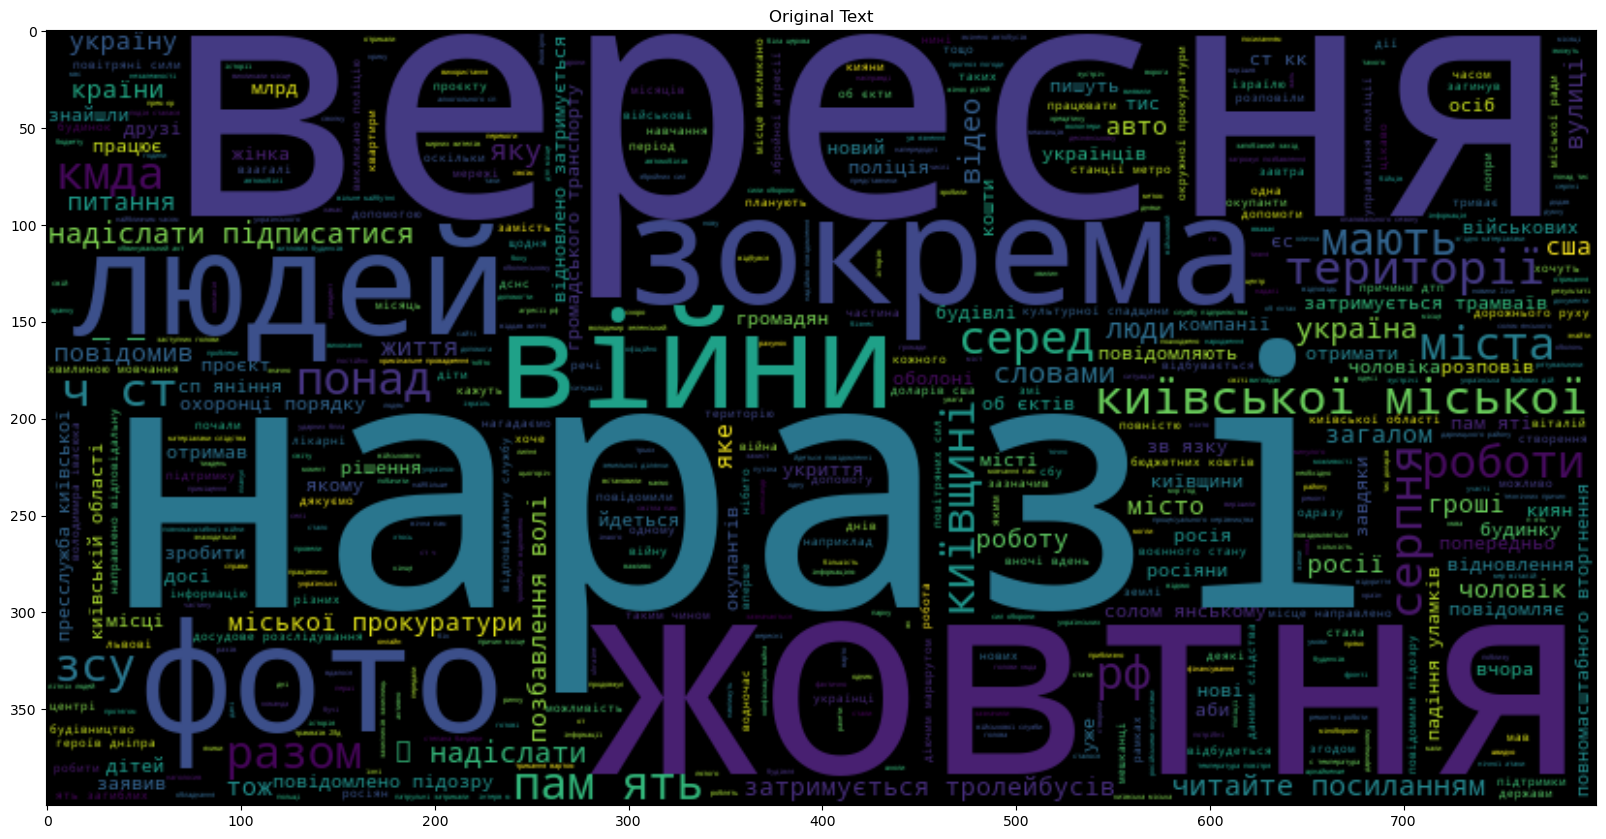

In [24]:
build_world_cloud(df[df['lang'] == 'uk']['token_text'])

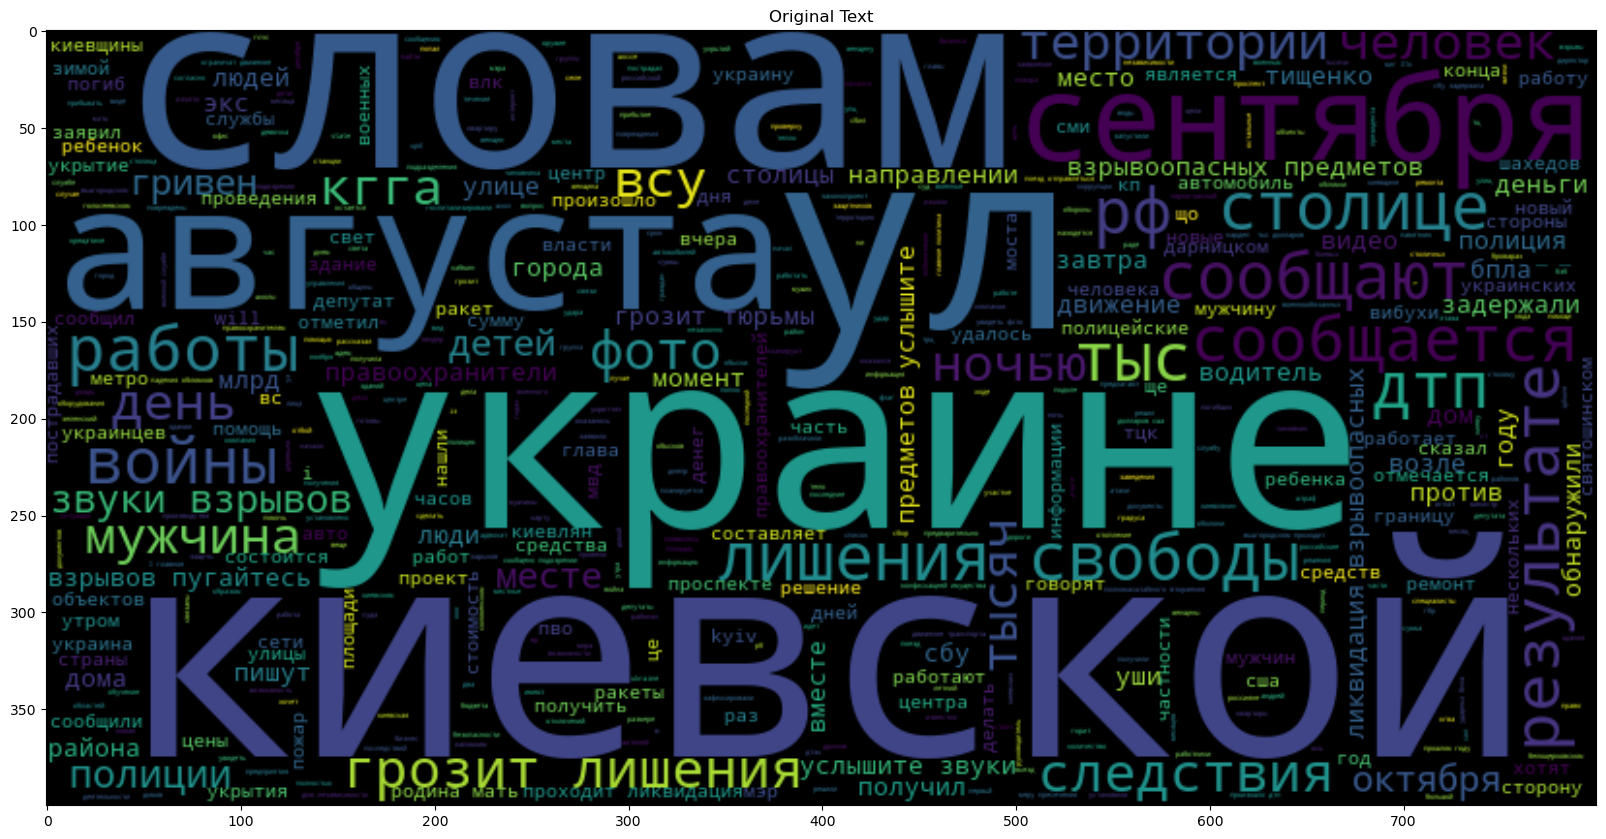

In [25]:
build_world_cloud(df[df['lang'] == 'ru']['token_text'])

There are still some unhelpful words, so we can raise number of most common words to delete, but for now we leave everything as it is.

In [41]:
df = df.reset_index(drop=True)

Drop duplicates 

In [42]:
drop_index = df['token_text'].drop_duplicates().index
df = df.iloc[drop_index]
df.shape

(28920, 8)

Drop empty texts

In [47]:
df = df[(df['token_text'] != '') & (df['tokens'].apply(lambda x: x != []))]
df.shape

(28919, 8)

# Save

In [48]:
df.to_csv('./data/processed_dataset.csv', index=False)